# Electricity Data Analysis
This notebook analyzes the first chunk of the P6269_1_50_DMK_Sample_Elek dataset, which was split from a larger 2.9GB CSV file.


## 1. Data Import and Setup
First, let's import the necessary libraries and load our dataset.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## 2. Loading the Data
We'll now load the first chunk of our dataset. Since we identified that the file uses semicolons as delimiters, we'll specify that in our read_csv call.


In [35]:
# Load the first chunk of the dataset
file_path = 'P6269_1_50_DMK_Sample_Elek/chunks/chunk_0.csv'

# First, let's peek at the file to confirm the delimiter
with open(file_path, 'r') as f:
    first_line = f.readline().strip()
    
print(f"First line of the file: {first_line}")

# Load the data with the proper delimiter
df = pd.read_csv(file_path, delimiter=';')

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")


First line of the file: EAN_ID;Datum;Datum_Startuur;Volume_Afname_kWh;Volume_Injectie_kWh;Warmtepomp_Indicator;Elektrisch_Voertuig_Indicator;PV-Installatie_Indicator;Contract_Categorie

Dataset shape: (100000, 9)
Memory usage: 6.87 MB


## 3. Column Translation and Data Type Conversion
The data is in Dutch, so let's translate the column names to English for better understanding and ensure proper data type conversion.


In [36]:
# Original column names and their meanings
column_translations = {
    'EAN_ID': 'EAN_ID',  # Unique identifier, keep as is
    'Datum': 'Date',  # Date
    'Datum_Startuur': 'Date_StartHour',  # Date with hour (timestamp)
    'Volume_Afname_kWh': 'Volume_Consumption_kWh',  # Electricity consumption
    'Volume_Injectie_kWh': 'Volume_Injection_kWh',  # Electricity fed back to grid
    'Warmtepomp_Indicator': 'Heat_Pump_Indicator',  # Whether household has heat pump (binary)
    'Elektrisch_Voertuig_Indicator': 'Electric_Vehicle_Indicator',  # Whether household has electric vehicle (binary)
    'PV-Installatie_Indicator': 'PV_Installation_Indicator',  # Whether household has solar panels (binary)
    'Contract_Categorie': 'Contract_Category'  # Category of contract
}

df.rename(columns=column_translations, inplace=True)
df


,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category
0,1,2022-01-01,2022-01-01T00:00:00.000Z,0.760,0.0,0,1,0,Residentieel
1,1,2022-01-01,2022-01-01T00:15:00.000Z,0.789,0.0,0,1,0,Residentieel
2,1,2022-01-01,2022-01-01T00:30:00.000Z,1.131,0.0,0,1,0,Residentieel
3,1,2022-01-01,2022-01-01T00:45:00.000Z,0.791,0.0,0,1,0,Residentieel
4,1,2022-01-01,2022-01-01T01:00:00.000Z,0.791,0.0,0,1,0,Residentieel
...,...,...,...,...,...,...,...,...,...
99995,3,2022-11-08,2022-11-08T14:45:00.000Z,0.103,0.0,0,0,0,Residentieel
99996,3,2022-11-08,2022-11-08T15:00:00.000Z,0.070,0.0,0,0,0,Residentieel
99997,3,2022-11-08,2022-11-08T15:15:00.000Z,0.065,0.0,0,0,0,Residentieel
99998,3,2022-11-08,2022-11-08T15:30:00.000Z,0.081,0.0,0,0,0,Residentieel


## 4. Exploring the Data Structure
Let's examine the columns and first few rows of our dataset.


In [37]:
# Display column names
print("Columns in the dataset:")
for col in df.columns:
    print(f"- {col}")

Columns in the dataset:
- EAN_ID
- Date
- Date_StartHour
- Volume_Consumption_kWh
- Volume_Injection_kWh
- Heat_Pump_Indicator
- Electric_Vehicle_Indicator
- PV_Installation_Indicator
- Contract_Category


In [38]:
# View the first few rows
print("First 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category
0,1,2022-01-01,2022-01-01T00:00:00.000Z,0.760,0.0,0,1,0,Residentieel
1,1,2022-01-01,2022-01-01T00:15:00.000Z,0.789,0.0,0,1,0,Residentieel
2,1,2022-01-01,2022-01-01T00:30:00.000Z,1.131,0.0,0,1,0,Residentieel
3,1,2022-01-01,2022-01-01T00:45:00.000Z,0.791,0.0,0,1,0,Residentieel
4,1,2022-01-01,2022-01-01T01:00:00.000Z,0.791,0.0,0,1,0,Residentieel


## 5. Data Cleaning and Type Conversion
Now let's convert numeric columns and handle any data type issues.


In [64]:
# For consumption and injection
for col in ['Volume_Consumption_kWh', 'Volume_Injection_kWh']:
    if col in df.columns:
        # Check current type
        current_type = df[col].dtype
        print(f"Converting {col} from {current_type}")
        
        # Convert to numeric
        if not pd.api.types.is_numeric_dtype(df[col]):
            # If string/object, handle comma as decimal separator
            df[col] = pd.to_numeric(df[col].astype(str).map(lambda x: x.replace(',', '.')), errors='coerce')
        else:
            # If already somewhat numeric but needs cleaning
            df[col] = pd.to_numeric(df[col], errors='coerce')


Converting Volume_Consumption_kWh from float64
Converting Volume_Injection_kWh from float64


In [45]:
df['Date_StartHour']=pd.to_datetime(df['Date_StartHour']).dt.tz_convert('Europe/Brussels')# Extract hour and create a new column
df['Date']=pd.to_datetime(df['Date'])
df['Hour'] = df['Date_StartHour'].dt.hour

# You can also extract other time components
df['Minute'] = df['Date_StartHour'].dt.minute
df['Day'] = df['Date_StartHour'].dt.day
df['Month'] = df['Date_StartHour'].dt.month
df['Year'] = df['Date_StartHour'].dt.year
df['Day_of_Week'] = df['Date_StartHour'].dt.dayofweek  # 0=Monday, 6=Sunday

In [63]:
for col in ['Heat_Pump_Indicator', 'Electric_Vehicle_Indicator', 'PV_Installation_Indicator']:
    if col in df.columns:
        df[col] = df[col].astype(int)

In [65]:
# Check data types after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype                          
---  ------                      --------------   -----                          
 0   EAN_ID                      100000 non-null  int64                          
 1   Date                        100000 non-null  datetime64[ns]                 
 2   Date_StartHour              100000 non-null  datetime64[ns, Europe/Brussels]
 3   Volume_Consumption_kWh      100000 non-null  float64                        
 4   Volume_Injection_kWh        100000 non-null  float64                        
 5   Heat_Pump_Indicator         100000 non-null  int64                          
 6   Electric_Vehicle_Indicator  100000 non-null  int64                          
 7   PV_Installation_Indicator   100000 non-null  int64                          
 8   Contract_Category           100000 non-null  object              

In [67]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
if any(missing_values > 0):
    for col in missing_values[missing_values > 0].index:
        print(f"- {col}: {missing_values[col]} missing values")
else:
    print("No missing values found")


Missing values per column:
No missing values found


In [66]:
df

,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category,Hour,Minute,Day,Month,Year,Day_of_Week
0,1,2022-01-01,2022-01-01 01:00:00+01:00,0.760,0.0,0,1,0,Residentieel,1,0,1,1,2022,5
1,1,2022-01-01,2022-01-01 01:15:00+01:00,0.789,0.0,0,1,0,Residentieel,1,15,1,1,2022,5
2,1,2022-01-01,2022-01-01 01:30:00+01:00,1.131,0.0,0,1,0,Residentieel,1,30,1,1,2022,5
3,1,2022-01-01,2022-01-01 01:45:00+01:00,0.791,0.0,0,1,0,Residentieel,1,45,1,1,2022,5
4,1,2022-01-01,2022-01-01 02:00:00+01:00,0.791,0.0,0,1,0,Residentieel,2,0,1,1,2022,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,2022-11-08,2022-11-08 15:45:00+01:00,0.103,0.0,0,0,0,Residentieel,15,45,8,11,2022,1
99996,3,2022-11-08,2022-11-08 16:00:00+01:00,0.070,0.0,0,0,0,Residentieel,16,0,8,11,2022,1
99997,3,2022-11-08,2022-11-08 16:15:00+01:00,0.065,0.0,0,0,0,Residentieel,16,15,8,11,2022,1
99998,3,2022-11-08,2022-11-08 16:30:00+01:00,0.081,0.0,0,0,0,Residentieel,16,30,8,11,2022,1


Making the sum for the weekend, week, month, quarter

## 6. Summary Statistics
Let's generate summary statistics for our numeric columns.


In [69]:
# Create time period columns for aggregation
df['Weekday_Weekend'] = df['Date_StartHour'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df['Week'] = df['Date_StartHour'].dt.isocalendar().week
df['Month'] = df['Date_StartHour'].dt.month
df['Quarter'] = df['Date_StartHour'].dt.quarter
df['Year'] = df['Date_StartHour'].dt.year

# Create aggregations for each time period
# 1. Weekend vs Weekday aggregation
weekend_agg = df.groupby('Weekday_Weekend').agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

# 2. Weekly aggregation
weekly_agg = df.groupby(['Year', 'Week']).agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

# 3. Monthly aggregation
monthly_agg = df.groupby(['Year', 'Month']).agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()
# Add month name for better readability
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_agg['Month_Name'] = monthly_agg['Month'].map(month_names)

# 4. Quarterly aggregation
quarterly_agg = df.groupby(['Year', 'Quarter']).agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()
quarterly_agg['Quarter_Label'] = quarterly_agg['Year'].astype(str) + '-Q' + quarterly_agg['Quarter'].astype(str)

# Print results
print("Weekend vs Weekday Energy Sums:")
print(weekend_agg)
print("\nWeekly Energy Sums:")
print(weekly_agg.head(10))  # Show first 10 weeks
print("\nMonthly Energy Sums:")
print(monthly_agg)
print("\nQuarterly Energy Sums:")
print(quarterly_agg)

# Create visualizations
import matplotlib.pyplot as plt
import os

# Create directory for results if it doesn't exist
os.makedirs('analysis_results', exist_ok=True)

# 1. Weekday vs Weekend bar chart
plt.figure(figsize=(10, 6))
plt.bar(weekend_agg['Weekday_Weekend'], weekend_agg['Volume_Consumption_kWh'], color='blue', alpha=0.7, label='Consumption')
plt.bar(weekend_agg['Weekday_Weekend'], weekend_agg['Volume_Injection_kWh'], color='green', alpha=0.7, label='Injection')
plt.title('Total Energy by Weekday vs Weekend')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('analysis_results/weekday_weekend_energy.png', dpi=300)
plt.close()

# 2. Monthly energy bar chart
plt.figure(figsize=(14, 8))
x = range(len(monthly_agg))
width = 0.4
plt.bar([i-width/2 for i in x], monthly_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar([i+width/2 for i in x], monthly_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')
plt.title('Monthly Energy Consumption and Injection')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.xticks(x, [f"{row['Year']}-{row['Month_Name']}" for _, row in monthly_agg.iterrows()], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('analysis_results/monthly_energy.png', dpi=300)
plt.close()

# 3. Quarterly energy bar chart
plt.figure(figsize=(12, 7))
x = range(len(quarterly_agg))
width = 0.4
plt.bar([i-width/2 for i in x], quarterly_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar([i+width/2 for i in x], quarterly_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')
plt.title('Quarterly Energy Consumption and Injection')
plt.xlabel('Quarter')
plt.ylabel('Energy (kWh)')
plt.xticks(x, quarterly_agg['Quarter_Label'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('analysis_results/quarterly_energy.png', dpi=300)
plt.close()

print("Visualizations saved to analysis_results directory")

Weekend vs Weekday Energy Sums:
  Weekday_Weekend  Volume_Consumption_kWh  Volume_Injection_kWh
0         Weekday               18210.976                   0.0
1         Weekend                7866.266                   0.0

Weekly Energy Sums:
   Year  Week  Volume_Consumption_kWh  Volume_Injection_kWh
0  2022     1                 451.253                   0.0
1  2022     2                 455.143                   0.0
2  2022     3                 416.238                   0.0
3  2022     4                 427.642                   0.0
4  2022     5                 680.018                   0.0
5  2022     6                 681.209                   0.0
6  2022     7                 697.875                   0.0
7  2022     8                 870.042                   0.0
8  2022     9                 836.725                   0.0
9  2022    10                 680.757                   0.0

Monthly Energy Sums:
    Year  Month  Volume_Consumption_kWh  Volume_Injection_kWh Month_Name


In [68]:
# Summary statistics for numeric columns
numeric_df = df.select_dtypes(include=['number'])
numeric_df.describe()

,EAN_ID,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Hour,Minute,Day,Month,Year,Day_of_Week
count,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.948800,0.260772,0.0,0.0,0.350400,0.0,11.498080,22.500000,15.635520,6.268440,2022.000080,3.004400
std,0.804354,0.336083,0.0,0.0,0.477098,0.0,6.921404,16.770594,8.819184,3.332976,0.008944,2.002504
min,1.000000,0.009000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,2022.000000,0.000000
25%,1.000000,0.074000,0.0,0.0,0.000000,0.0,5.000000,11.250000,8.000000,3.000000,2022.000000,1.000000
50%,2.000000,0.115000,0.0,0.0,0.000000,0.0,11.000000,22.500000,16.000000,6.000000,2022.000000,3.000000
75%,3.000000,0.329000,0.0,0.0,1.000000,0.0,17.000000,33.750000,23.000000,9.000000,2022.000000,5.000000
max,3.000000,3.255000,0.0,0.0,1.000000,0.0,23.000000,45.000000,31.000000,12.000000,2023.000000,6.000000


## 7. Exploratory Data Analysis
Now let's analyze the data to gain insights about the electricity consumption patterns.


## 7.1 Basic Data Exploration

In [50]:
# Set a better style for the plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

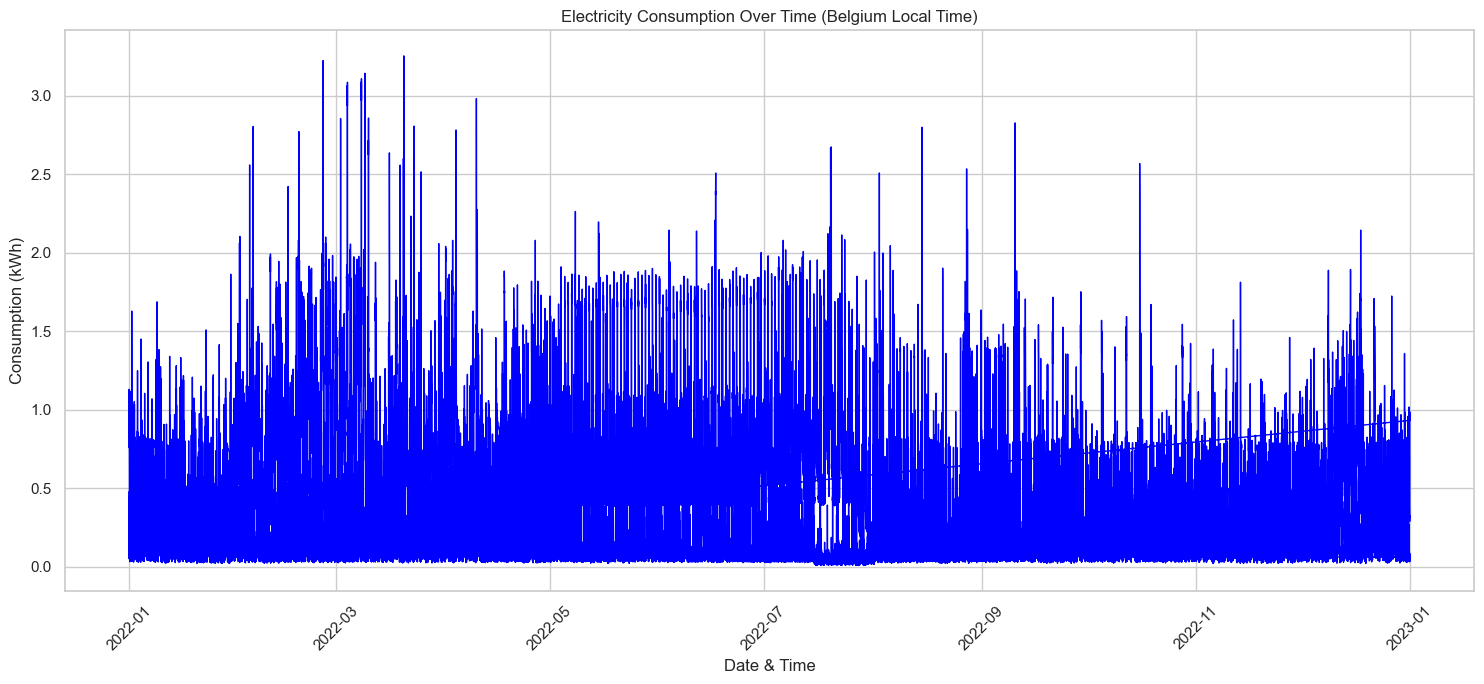

In [54]:
# 1. Plot consumption (Volume_Afname_kWh) over time
plt.figure(figsize=(15, 7))
plt.plot(df['Date_StartHour'], df['Volume_Consumption_kWh'], color='blue', linewidth=1)
plt.title('Electricity Consumption Over Time (Belgium Local Time)')
plt.xlabel('Date & Time')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('analysis_results/consumption_over_time.png', dpi=300)
plt.close()



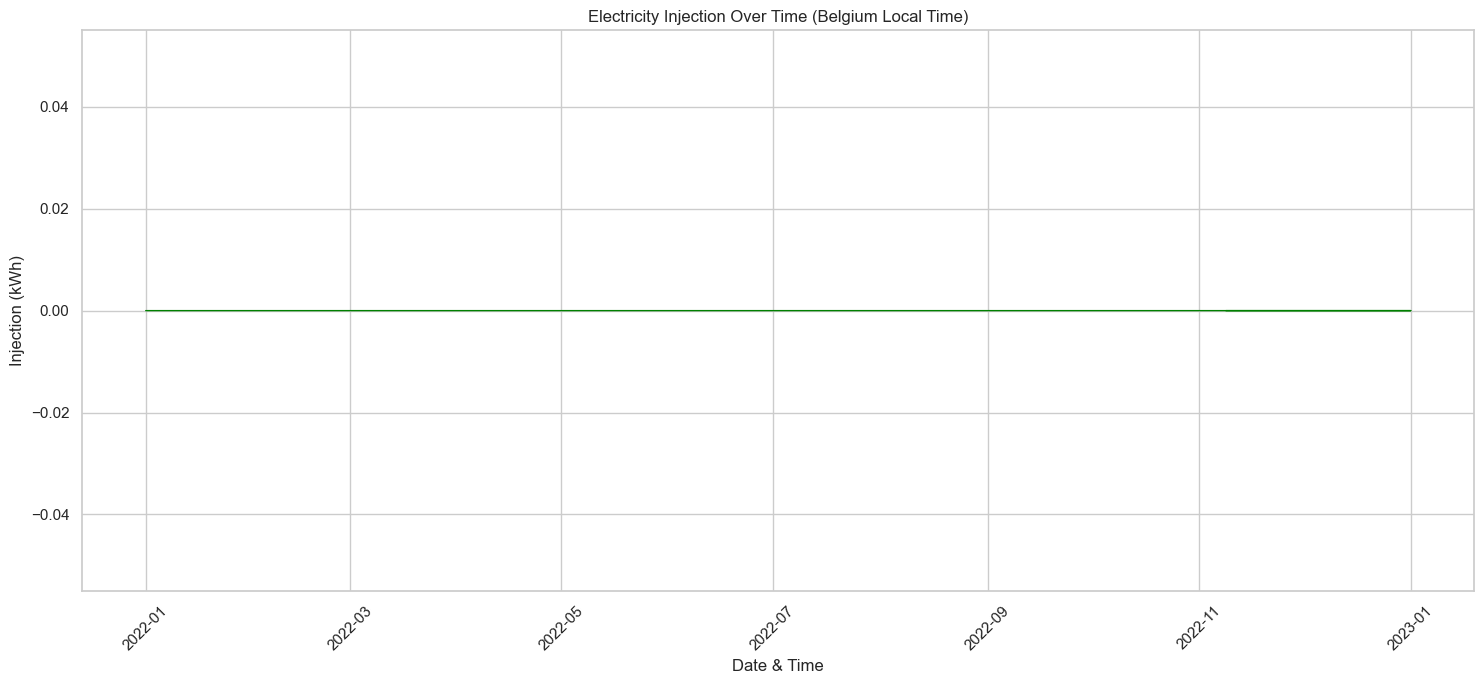

In [55]:
# 2. Plot injection (Volume_Injectie_kWh) over time
plt.figure(figsize=(15, 7))
plt.plot(df['Date_StartHour'], df['Volume_Injection_kWh'], color='green', linewidth=1)
plt.title('Electricity Injection Over Time (Belgium Local Time)')
plt.xlabel('Date & Time')
plt.ylabel('Injection (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('analysis_results/injection_over_time.png', dpi=300)
plt.close()

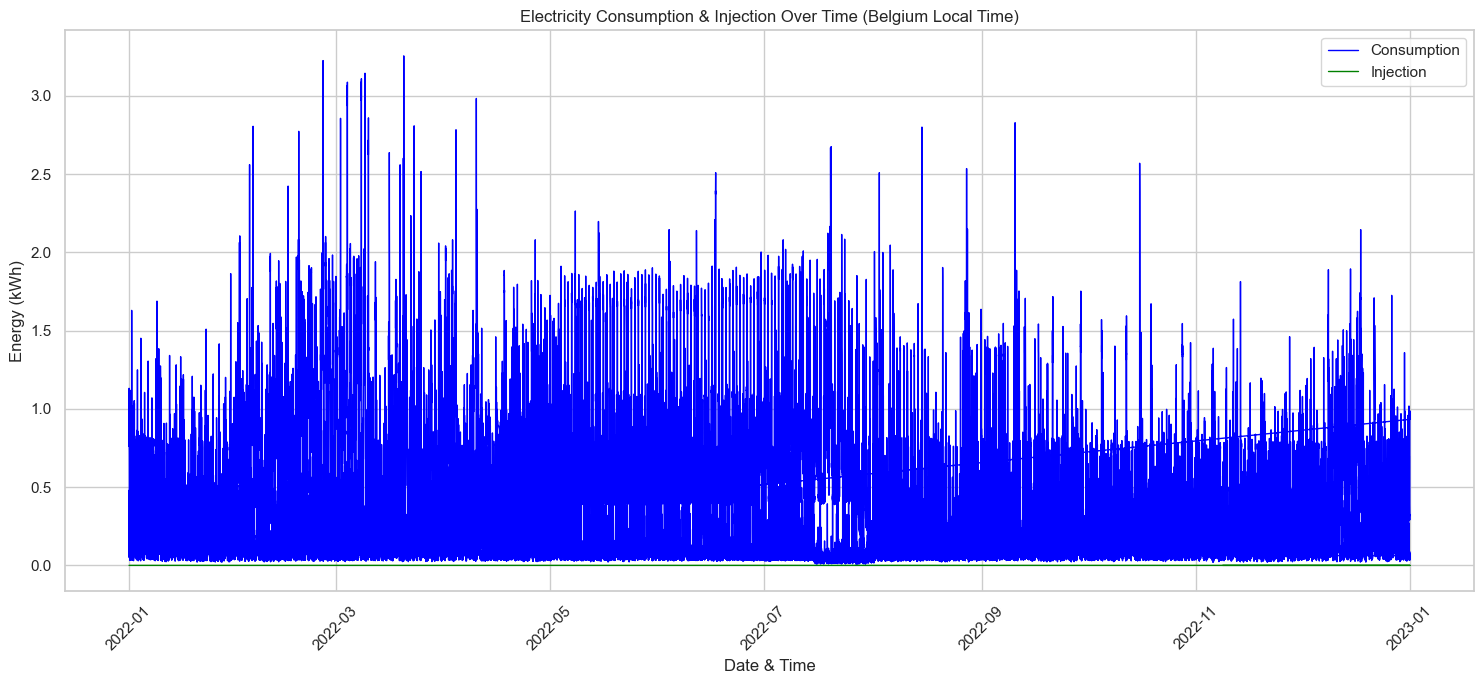

In [58]:
# 3. Plot both consumption and injection together
plt.figure(figsize=(15, 7))
plt.plot(df['Date_StartHour'], df['Volume_Consumption_kWh'], color='blue', linewidth=1, label='Consumption')
plt.plot(df['Date_StartHour'], df['Volume_Injection_kWh'], color='green', linewidth=1, label='Injection')
plt.title('Electricity Consumption & Injection Over Time (Belgium Local Time)')
plt.xlabel('Date & Time')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('analysis_results/consumption_and_injection_over_time.png', dpi=300)
plt.close()


### 7.2 Time-Based Aggregation Analysis

Let's analyze consumption and injection patterns by different time periods.


Weekend vs Weekday Energy Sums:


,Weekday_Weekend,Volume_Consumption_kWh,Volume_Injection_kWh
0,Weekday,18210.976,0.0
1,Weekend,7866.266,0.0


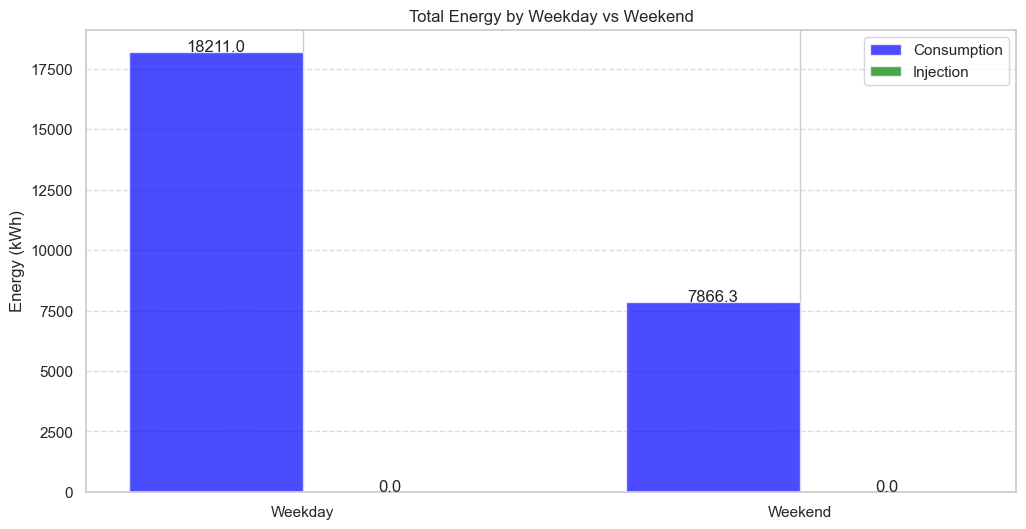

Weekday consumption: 69.8% of total
Weekend consumption: 30.2% of total


In [72]:
# Weekday vs Weekend aggregation
weekend_agg = df.groupby('Weekday_Weekend').agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

print("Weekend vs Weekday Energy Sums:")
display(weekend_agg)

# Calculate percentage differences
total_consumption = weekend_agg['Volume_Consumption_kWh'].sum()
total_injection = weekend_agg['Volume_Injection_kWh'].sum()
weekend_agg['Consumption_Percentage'] = weekend_agg['Volume_Consumption_kWh'] / total_consumption * 100
weekend_agg['Injection_Percentage'] = weekend_agg['Volume_Injection_kWh'] / total_injection * 100

# Visualize weekday vs weekend
plt.figure(figsize=(12, 6))
x = weekend_agg['Weekday_Weekend']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, weekend_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, weekend_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')

# Add value labels on top of bars
for i, v in enumerate(weekend_agg['Volume_Consumption_kWh']):
    plt.text(i - width/2, v + 5, f'{v:.1f}', ha='center')
    
for i, v in enumerate(weekend_agg['Volume_Injection_kWh']):
    plt.text(i + width/2, v + 5, f'{v:.1f}', ha='center')

plt.title('Total Energy by Weekday vs Weekend')
plt.ylabel('Energy (kWh)')
plt.xticks(x_pos, x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('analysis_results/weekday_weekend_energy.png', dpi=300)
plt.show()

print(f"Weekday consumption: {weekend_agg.loc[weekend_agg['Weekday_Weekend'] == 'Weekday', 'Consumption_Percentage'].values[0]:.1f}% of total")
print(f"Weekend consumption: {weekend_agg.loc[weekend_agg['Weekday_Weekend'] == 'Weekend', 'Consumption_Percentage'].values[0]:.1f}% of total")


## 7.3 Daily Analysis

Daily Energy Sums:


,Day_Name,Volume_Consumption_kWh,Volume_Injection_kWh
1,Monday,3704.743,0.0
5,Tuesday,3423.284,0.0
6,Wednesday,3902.785,0.0
4,Thursday,3476.379,0.0
0,Friday,3703.785,0.0
2,Saturday,3984.658,0.0
3,Sunday,3881.608,0.0


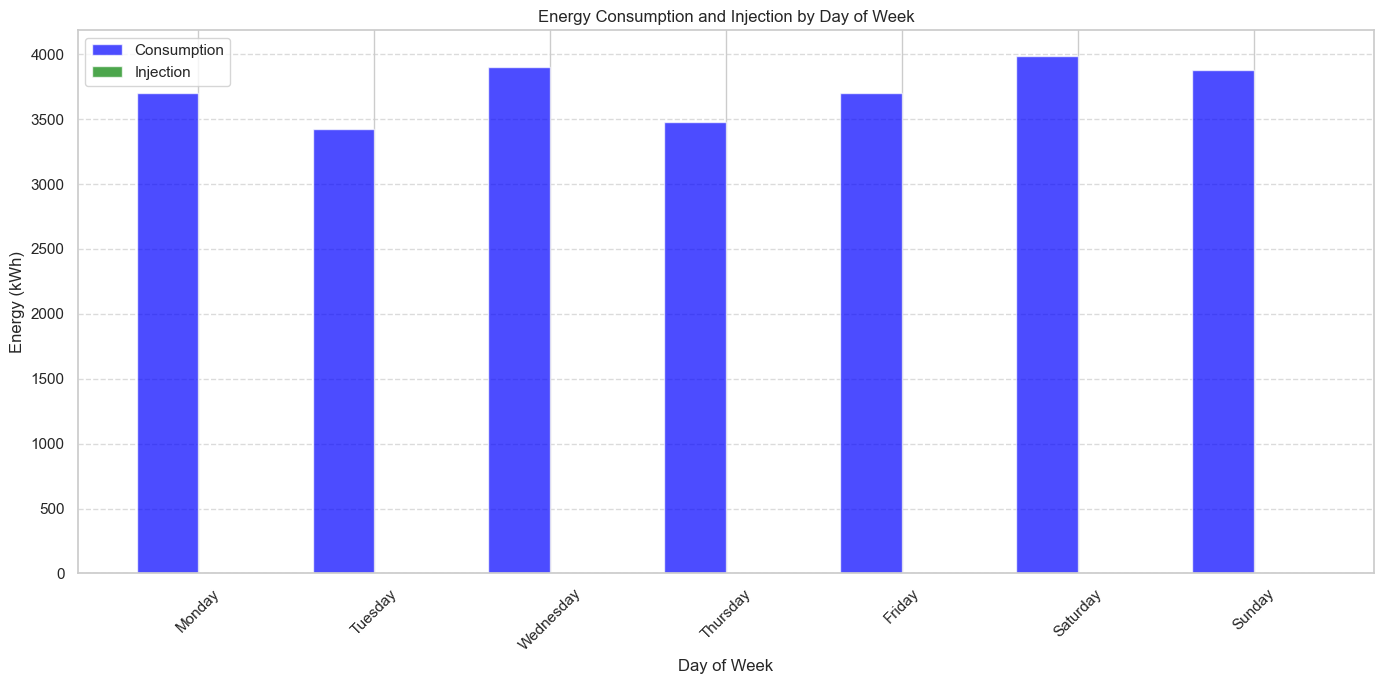

In [75]:


df['Day_Name'] = df['Date_StartHour'].dt.day_name()

# Daily aggregation
daily_agg = df.groupby('Day_Name').agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

# Ensure days of week are in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_agg['Day_Order'] = daily_agg['Day_Name'].map(lambda x: day_order.index(x))
daily_agg = daily_agg.sort_values('Day_Order').drop('Day_Order', axis=1)

print("Daily Energy Sums:")
display(daily_agg)

# Visualize daily patterns
plt.figure(figsize=(14, 7))
x = daily_agg['Day_Name']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, daily_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, daily_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')

plt.title('Energy Consumption and Injection by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Energy (kWh)')
plt.xticks(x_pos, x, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('analysis_results/daily_energy.png', dpi=300)
plt.show()


## 7.4 Monthly Analysis

Monthly Energy Sums:


,Year,Month,Volume_Consumption_kWh,Volume_Injection_kWh,Month_Name,Period
0,2022,1,1964.158,0.0,Jan,2022-Jan
1,2022,2,2960.179,0.0,Feb,2022-Feb
2,2022,3,2885.820,0.0,Mar,2022-Mar
3,2022,4,2257.582,0.0,Apr,2022-Apr
4,2022,5,2775.396,0.0,May,2022-May
5,2022,6,2644.073,0.0,Jun,2022-Jun
6,2022,7,2559.828,0.0,Jul,2022-Jul
7,2022,8,1519.831,0.0,Aug,2022-Aug
8,2022,9,1691.246,0.0,Sep,2022-Sep
9,2022,10,1653.882,0.0,Oct,2022-Oct


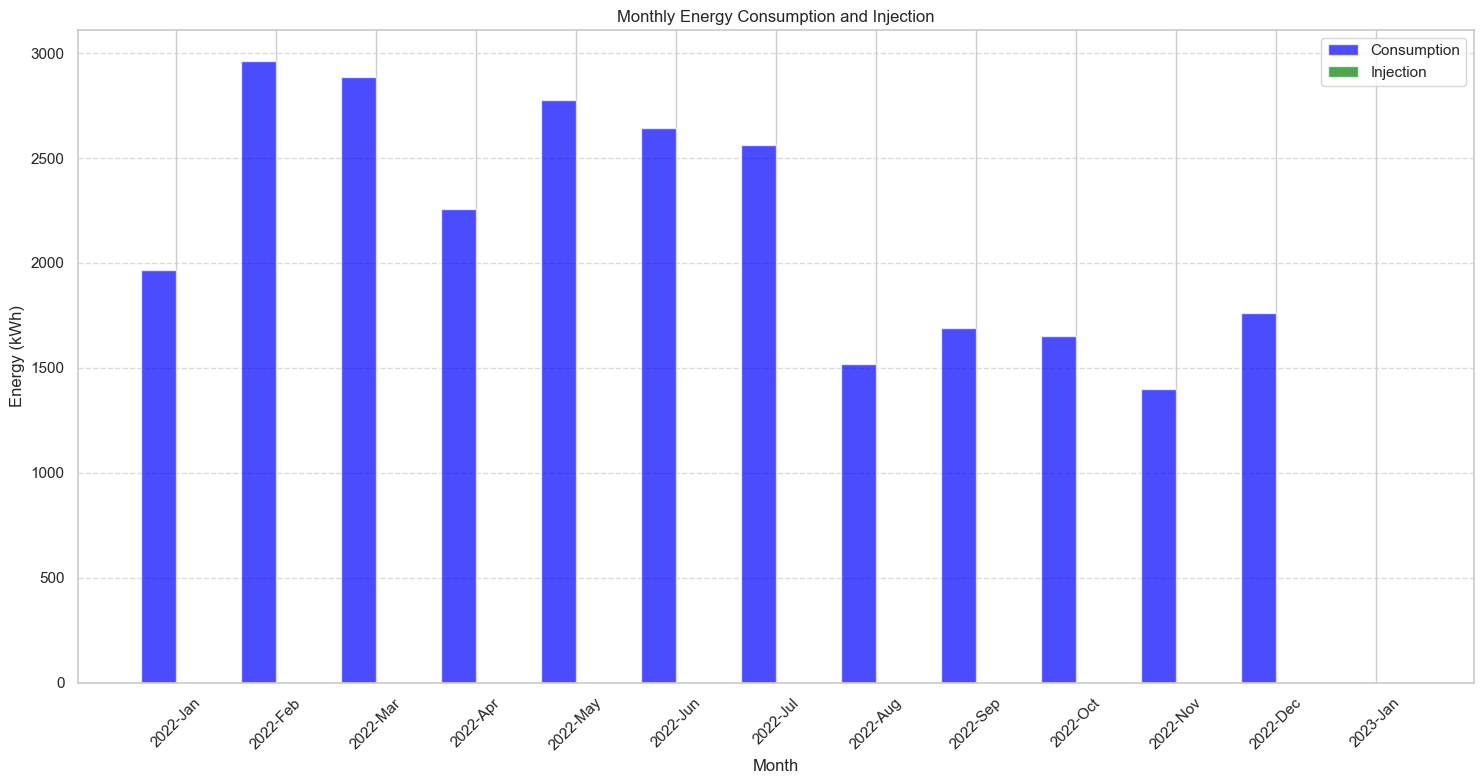

In [76]:


# Monthly aggregation
monthly_agg = df.groupby(['Year', 'Month']).agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

# Add month name for better readability
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_agg['Month_Name'] = monthly_agg['Month'].map(month_names)
monthly_agg['Period'] = monthly_agg['Year'].astype(str) + '-' + monthly_agg['Month_Name']

print("Monthly Energy Sums:")
display(monthly_agg)

# Visualize monthly patterns
plt.figure(figsize=(15, 8))
x = monthly_agg['Period']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, monthly_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, monthly_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')

plt.title('Monthly Energy Consumption and Injection')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.xticks(x_pos, x, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('analysis_results/monthly_energy.png', dpi=300)
plt.show()


## 8.4 Quarterly Analysis

Quarterly Energy Sums:


,Year,Quarter,Volume_Consumption_kWh,Volume_Injection_kWh,Quarter_Label
0,2022,1,7810.157,0.0,2022-Q1
1,2022,2,7677.051,0.0,2022-Q2
2,2022,3,5770.905,0.0,2022-Q3
3,2022,4,4815.084,0.0,2022-Q4
4,2023,1,4.045,0.0,2023-Q1


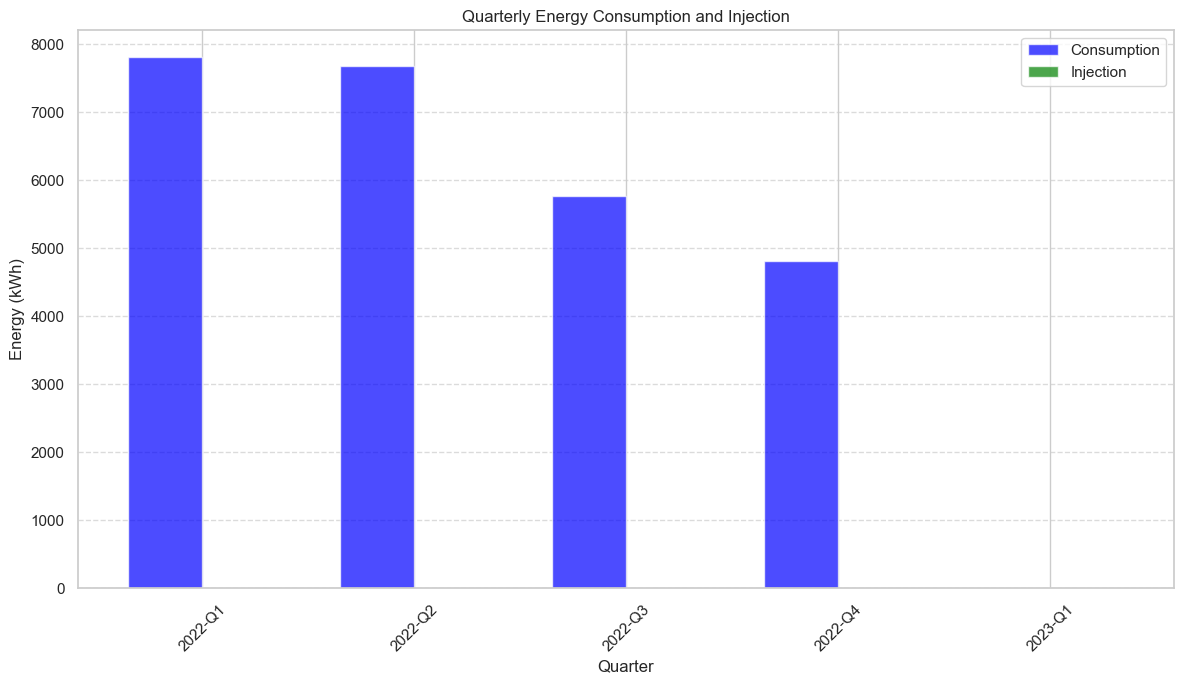

In [77]:

# Quarterly aggregation
quarterly_agg = df.groupby(['Year', 'Quarter']).agg({
    'Volume_Consumption_kWh': 'sum',
    'Volume_Injection_kWh': 'sum'
}).reset_index()

quarterly_agg['Quarter_Label'] = quarterly_agg['Year'].astype(str) + '-Q' + quarterly_agg['Quarter'].astype(str)

print("Quarterly Energy Sums:")
display(quarterly_agg)

# Visualize quarterly patterns
plt.figure(figsize=(12, 7))
x = quarterly_agg['Quarter_Label']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, quarterly_agg['Volume_Consumption_kWh'], width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, quarterly_agg['Volume_Injection_kWh'], width=width, color='green', alpha=0.7, label='Injection')

plt.title('Quarterly Energy Consumption and Injection')
plt.xlabel('Quarter')
plt.ylabel('Energy (kWh)')
plt.xticks(x_pos, x, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('analysis_results/quarterly_energy.png', dpi=300)
plt.show()


## 7.5 Hourly Pattern Analysis

Hourly Energy Averages:


,Hour,Volume_Consumption_kWh,Volume_Injection_kWh
0,0,0.392409,0.0
1,1,0.265640,0.0
2,2,0.214218,0.0
3,3,0.214897,0.0
4,4,0.280973,0.0
5,5,0.287939,0.0
6,6,0.259137,0.0
7,7,0.240074,0.0
8,8,0.215004,0.0
9,9,0.208557,0.0


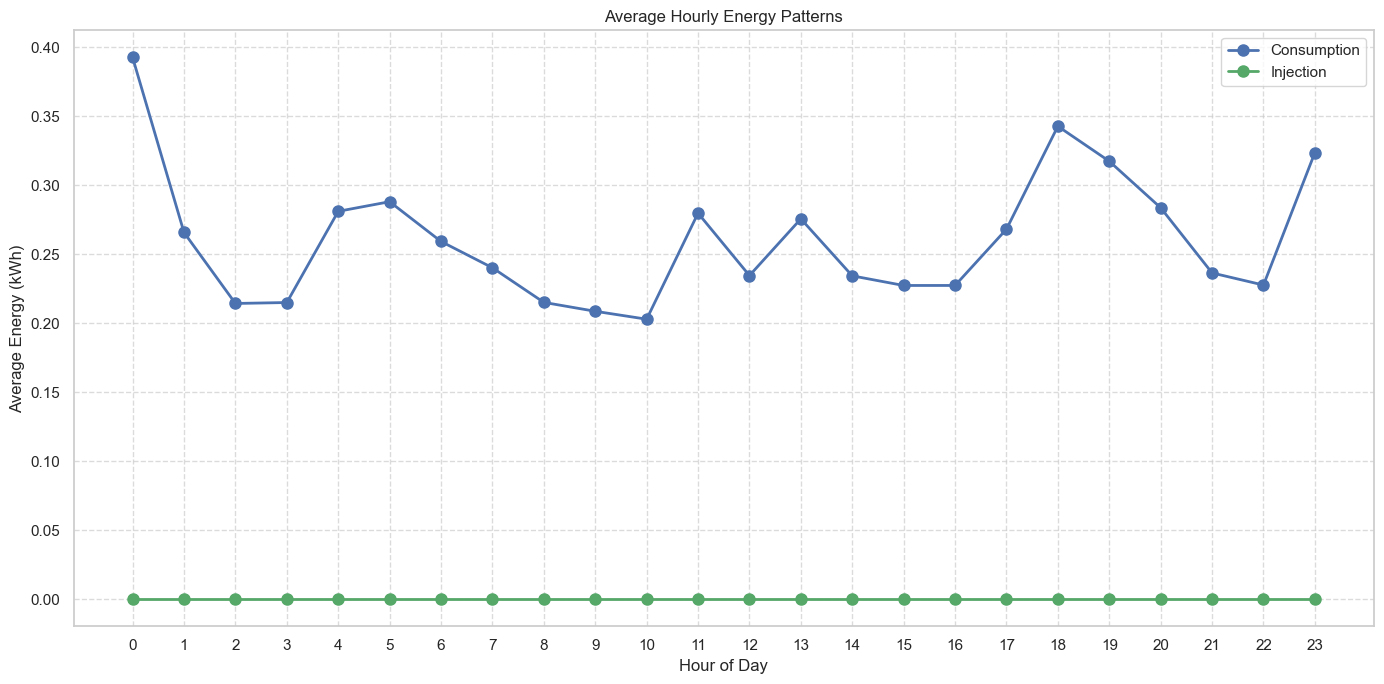


Peak consumption hours:
- Hour 0: 0.3924 kWh
- Hour 18: 0.3426 kWh
- Hour 23: 0.3235 kWh

Peak injection hours:
- Hour 0: 0.0000 kWh
- Hour 1: 0.0000 kWh
- Hour 2: 0.0000 kWh


In [78]:


# Hourly aggregation
hourly_avg = df.groupby('Hour').agg({
    'Volume_Consumption_kWh': 'mean',
    'Volume_Injection_kWh': 'mean'
}).reset_index()

print("Hourly Energy Averages:")
display(hourly_avg)

# Visualize hourly patterns
plt.figure(figsize=(14, 7))
plt.plot(hourly_avg['Hour'], hourly_avg['Volume_Consumption_kWh'], 'b-o', linewidth=2, markersize=8, label='Consumption')
plt.plot(hourly_avg['Hour'], hourly_avg['Volume_Injection_kWh'], 'g-o', linewidth=2, markersize=8, label='Injection')
plt.title('Average Hourly Energy Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy (kWh)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('analysis_results/hourly_energy_patterns.png', dpi=300)
plt.show()

# Find peak hours
peak_consumption_hours = hourly_avg.nlargest(3, 'Volume_Consumption_kWh')
peak_injection_hours = hourly_avg.nlargest(3, 'Volume_Injection_kWh')

print("\nPeak consumption hours:")
for _, row in peak_consumption_hours.iterrows():
    print(f"- Hour {int(row['Hour'])}: {row['Volume_Consumption_kWh']:.4f} kWh")

print("\nPeak injection hours:")
for _, row in peak_injection_hours.iterrows():
    print(f"- Hour {int(row['Hour'])}: {row['Volume_Injection_kWh']:.4f} kWh")


## 7.6 Analysis by EV

Energy patterns by electric vehicle ownership:


,Consumption_Mean,Consumption_Median,Consumption_StdDev,Consumption_Sum,Injection_Mean,Injection_Median,Injection_StdDev,Injection_Sum,Unique_Households
No EV,0.126163,0.086,0.133392,8195.548,0.0,0.0,0.0,0.0,2
Has EV,0.510322,0.422,0.439886,17881.694,0.0,0.0,0.0,0.0,1



EV owners consume 304.49% more electricity on average


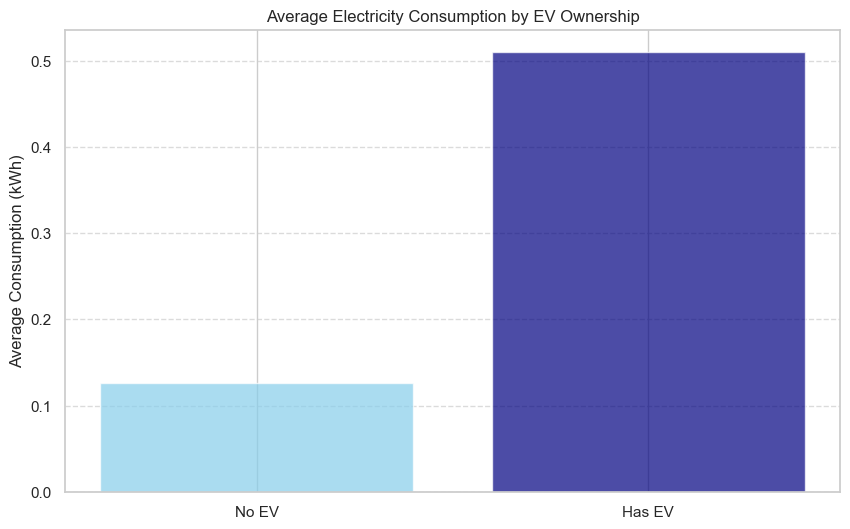

In [79]:

# Analyze consumption by electric vehicle ownership
if 'Electric_Vehicle_Indicator' in df.columns:
    ev_group = df.groupby('Electric_Vehicle_Indicator').agg({
        'Volume_Consumption_kWh': ['mean', 'median', 'std', 'sum'],
        'Volume_Injection_kWh': ['mean', 'median', 'std', 'sum'],
        'EAN_ID': 'nunique'  # Count unique households
    })
    
    ev_group.columns = ['Consumption_Mean', 'Consumption_Median', 'Consumption_StdDev', 'Consumption_Sum',
                        'Injection_Mean', 'Injection_Median', 'Injection_StdDev', 'Injection_Sum',
                        'Unique_Households']
    
    ev_group.index = ['No EV', 'Has EV']
    
    print("Energy patterns by electric vehicle ownership:")
    display(ev_group)
    
    # Calculate percentage differences
    ev_increase = (ev_group.loc['Has EV', 'Consumption_Mean'] / ev_group.loc['No EV', 'Consumption_Mean'] - 1) * 100
    
    print(f"\nEV owners consume {ev_increase:.2f}% more electricity on average")
    
    # Visualize EV vs non-EV consumption
    plt.figure(figsize=(10, 6))
    plt.bar(['No EV', 'Has EV'], [ev_group.loc['No EV', 'Consumption_Mean'], ev_group.loc['Has EV', 'Consumption_Mean']], 
            color=['skyblue', 'navy'], alpha=0.7)
    plt.title('Average Electricity Consumption by EV Ownership')
    plt.ylabel('Average Consumption (kWh)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('analysis_results/ev_consumption_comparison.png', dpi=300)
    plt.show()

In [86]:
df

,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category,Hour,Minute,Day,Month,Year,Day_of_Week,Weekday_Weekend,Week,Quarter,Day_Name
0,1,2022-01-01,2022-01-01 01:00:00+01:00,0.760,0.0,0,1,0,Residentieel,1,0,1,1,2022,5,Weekend,52,1,Saturday
1,1,2022-01-01,2022-01-01 01:15:00+01:00,0.789,0.0,0,1,0,Residentieel,1,15,1,1,2022,5,Weekend,52,1,Saturday
2,1,2022-01-01,2022-01-01 01:30:00+01:00,1.131,0.0,0,1,0,Residentieel,1,30,1,1,2022,5,Weekend,52,1,Saturday
3,1,2022-01-01,2022-01-01 01:45:00+01:00,0.791,0.0,0,1,0,Residentieel,1,45,1,1,2022,5,Weekend,52,1,Saturday
4,1,2022-01-01,2022-01-01 02:00:00+01:00,0.791,0.0,0,1,0,Residentieel,2,0,1,1,2022,5,Weekend,52,1,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,2022-11-08,2022-11-08 15:45:00+01:00,0.103,0.0,0,0,0,Residentieel,15,45,8,11,2022,1,Weekday,45,4,Tuesday
99996,3,2022-11-08,2022-11-08 16:00:00+01:00,0.070,0.0,0,0,0,Residentieel,16,0,8,11,2022,1,Weekday,45,4,Tuesday
99997,3,2022-11-08,2022-11-08 16:15:00+01:00,0.065,0.0,0,0,0,Residentieel,16,15,8,11,2022,1,Weekday,45,4,Tuesday
99998,3,2022-11-08,2022-11-08 16:30:00+01:00,0.081,0.0,0,0,0,Residentieel,16,30,8,11,2022,1,Weekday,45,4,Tuesday


# 8. Calendar Feature Engineering and Holiday Analysis

 In this section, we'll enrich our dataset with Belgian calendar features including:
    1. National/bank holidays
    2. School holiday periods

Then we'll analyze how these calendar events affect energy consumption and injection patterns.


## 8.1 Adding Belgian Holiday Features

First, we'll add Belgian national holidays to our dataset. We'll use the holidays library for this, which provides accurate holiday information for many countries including Belgium.


In [87]:
# Install holidays library if not already installed
try:
    import holidays
except ImportError:
    print("Installing holidays library...")
    !pip install holidays
    import holidays

import holidays
from datetime import datetime, timedelta

# Create a Belgian holidays dictionary for the years in our dataset
min_year = df['Date'].dt.year.min()
max_year = df['Date'].dt.year.max()
print(f"Dataset spans from {min_year} to {max_year}")

# Create Belgian holidays dictionary
be_holidays = holidays.Belgium(years=range(min_year, max_year + 1))

# Function to check if a date is a Belgian holiday
def is_belgian_holiday(date):
    return date in be_holidays

# Add holiday indicator and name to dataframe
df['Is_Holiday'] = df['Date'].apply(is_belgian_holiday).astype(int)
df['Holiday_Name'] = df['Date'].apply(lambda date: be_holidays.get(date) if date in be_holidays else None)

# Display holidays found in the dataset
holidays_in_data = df[df['Is_Holiday'] == 1][['Date', 'Holiday_Name']].drop_duplicates().sort_values('Date')
print(f"\nBelgian holidays found in dataset ({len(holidays_in_data)} holidays):")
display(holidays_in_data)

Installing holidays library...
     ------------------------------------- 863.9/863.9 KB 10.9 MB/s eta 0:00:00
Dataset spans from 2022 to 2022


You should consider upgrading via the 'C:\Users\aleks\Desktop\Energy_Thesis\venv\Scripts\python.exe -m pip install --upgrade pip' command.



Belgian holidays found in dataset (12 holidays):


,Date,Holiday_Name
0,2022-01-01,Nieuwjaar
10176,2022-04-17,Pasen
10272,2022-04-18,Paasmaandag
11520,2022-05-01,Dag van de Arbeid
13920,2022-05-26,O. L. H. Hemelvaart
14880,2022-06-05,Pinksteren
14976,2022-06-06,Pinkstermaandag
19296,2022-07-21,Nationale feestdag
21696,2022-08-15,O. L. V. Hemelvaart
29184,2022-11-01,Allerheiligen


## 8.2 Adding Belgian School Holiday Periods

Now we'll add Belgian school holiday periods. These vary slightly by year and region, but we'll use the general patterns for Flanders region, which is the most populated region of Belgium.


In [ ]:
# Define Belgian school holiday periods (approximate dates for Flanders)
# Source: https://onderwijs.vlaanderen.be/nl/schoolvakanties (Flemish Government Education Portal)
# and https://www.schoolvakanties-belgie.be/ (School Holiday Portal)


In [116]:
# Define Belgian school holiday periods (approximate dates for Flanders)
# Source: https://onderwijs.vlaanderen.be/nl/schoolvakanties (Flemish Government Education Portal)
# and https://www.schoolvakanties-belgie.be/ (School Holiday Portal)

def get_school_holidays(year):
    """Return a dictionary of school holiday periods for a given year in Belgium (Flanders)"""
    holidays = {}
    
    # Fall Break (Herfstvakantie) - 1 week around Nov 1
    fall_start = datetime(year, 10, 31) - timedelta(days=datetime(year, 10, 31).weekday())
    holidays[(fall_start, fall_start + timedelta(days=6))] = "Fall Break"
    
    # Christmas Break (Kerstvakantie) - 2 weeks including Christmas and New Year
    xmas_start = datetime(year, 12, 24) - timedelta(days=datetime(year, 12, 24).weekday())
    if xmas_start.day > 20:  # If Christmas Eve is late in the week, start the break earlier
        xmas_start = xmas_start - timedelta(days=7)
    # Extend Christmas break to first week of next year
    holidays[(xmas_start, datetime(year + 1, 1, 7))] = "Christmas Break"
    
    # Spring Break (Krokusvakantie) - 1 week in Feb/Mar (variable)
    if year == 2022:
        spring_start = datetime(year, 2, 28)
    elif year == 2023:
        spring_start = datetime(year, 2, 20)
    else:
        # Approximate for other years - usually last week of February
        spring_start = datetime(year, 2, 28) - timedelta(days=datetime(year, 2, 28).weekday())
    holidays[(spring_start, spring_start + timedelta(days=6))] = "Spring Break"
    
    # Easter Break (Paasvakantie) - 2 weeks around Easter
    # This is complex to calculate exactly, so approximate based on known dates
    if year == 2022:
        easter_start = datetime(year, 4, 4)
    elif year == 2023:
        easter_start = datetime(year, 4, 3)
    else:
        # Approximate for other years - usually first 2 weeks of April
        easter_start = datetime(year, 4, 1)
    holidays[(easter_start, easter_start + timedelta(days=13))] = "Easter Break"
    
    # Summer Break (Zomervakantie) - July and August
    summer_start = datetime(year, 7, 1)
    holidays[(summer_start, datetime(year, 8, 31))] = "Summer Break"
    
    return holidays

# Create a function to check if a date falls within school holidays
def get_school_holiday_name(date):
    # Handle both datetime objects and integer years
    if isinstance(date, (int, np.integer)):
        year = date
        # For year-only input, return None as we need a specific date
        return None
    else:
        # Check if date falls in first week of year (part of previous year's Christmas break)
        if date.month == 1 and date.day <= 7:
            prev_year_holidays = get_school_holidays(date.year - 1)
            for (start, end), name in prev_year_holidays.items():
                if name == "Christmas Break" and start.year == date.year - 1:
                    if start <= date <= end:
                        return name
        
        # Check current year's holidays
        year = date.year
        school_holidays = get_school_holidays(year)
        
        # Check if the date falls within any holiday period
        for (start, end), name in school_holidays.items():
            if start <= date <= end:
                return name
        
        return None

# Add school holiday indicator to dataframe
df['School_Holiday'] = df['Date'].apply(lambda x: get_school_holiday_name(x))
df['Is_School_Holiday'] = df['School_Holiday'].notna().astype(int)

# Display school holiday periods found in the dataset
school_holidays_in_data = df[df['Is_School_Holiday'] == 1][['Date', 'School_Holiday']].drop_duplicates().sort_values('Date')
print(f"\nSchool holiday periods found in dataset:")
display(school_holidays_in_data.head(10))  # Show first 10 for brevity
print(f"Total school holiday dates: {len(school_holidays_in_data)}")

# Count by holiday type
holiday_counts = df[df['Is_School_Holiday'] == 1]['School_Holiday'].value_counts()
print("\nSchool holiday distribution:")
display(holiday_counts)


School holiday periods found in dataset:


,Date,School_Holiday
0,2022-01-01,Christmas Break
96,2022-01-02,Christmas Break
192,2022-01-03,Christmas Break
288,2022-01-04,Christmas Break
384,2022-01-05,Christmas Break
480,2022-01-06,Christmas Break
576,2022-01-07,Christmas Break
5568,2022-02-28,Spring Break
5664,2022-03-01,Spring Break
5760,2022-03-02,Spring Break


Total school holiday dates: 110

School holiday distribution:


School_Holiday
Summer Break       17856
Christmas Break     4512
Easter Break        4032
Spring Break        2016
Fall Break          2016
Name: count, dtype: int64

In [117]:
df

,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category,Hour,Minute,Day,Month,Year,Day_of_Week,Weekday_Weekend,Week,Quarter,Day_Name,Is_Holiday,Holiday_Name,School_Holiday,Is_School_Holiday,Season,Is_Weekend,Day_Type
0,1,2022-01-01,2022-01-01 01:00:00+01:00,0.760,0.0,0,1,0,Residentieel,1,0,1,1,2022,5,Weekend,52,1,Saturday,1,Nieuwjaar,Christmas Break,1,Winter,1,Holiday
1,1,2022-01-01,2022-01-01 01:15:00+01:00,0.789,0.0,0,1,0,Residentieel,1,15,1,1,2022,5,Weekend,52,1,Saturday,1,Nieuwjaar,Christmas Break,1,Winter,1,Holiday
2,1,2022-01-01,2022-01-01 01:30:00+01:00,1.131,0.0,0,1,0,Residentieel,1,30,1,1,2022,5,Weekend,52,1,Saturday,1,Nieuwjaar,Christmas Break,1,Winter,1,Holiday
3,1,2022-01-01,2022-01-01 01:45:00+01:00,0.791,0.0,0,1,0,Residentieel,1,45,1,1,2022,5,Weekend,52,1,Saturday,1,Nieuwjaar,Christmas Break,1,Winter,1,Holiday
4,1,2022-01-01,2022-01-01 02:00:00+01:00,0.791,0.0,0,1,0,Residentieel,2,0,1,1,2022,5,Weekend,52,1,Saturday,1,Nieuwjaar,Christmas Break,1,Winter,1,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,2022-11-08,2022-11-08 15:45:00+01:00,0.103,0.0,0,0,0,Residentieel,15,45,8,11,2022,1,Weekday,45,4,Tuesday,0,None,None,0,Fall,0,Weekday
99996,3,2022-11-08,2022-11-08 16:00:00+01:00,0.070,0.0,0,0,0,Residentieel,16,0,8,11,2022,1,Weekday,45,4,Tuesday,0,None,None,0,Fall,0,Weekday
99997,3,2022-11-08,2022-11-08 16:15:00+01:00,0.065,0.0,0,0,0,Residentieel,16,15,8,11,2022,1,Weekday,45,4,Tuesday,0,None,None,0,Fall,0,Weekday
99998,3,2022-11-08,2022-11-08 16:30:00+01:00,0.081,0.0,0,0,0,Residentieel,16,30,8,11,2022,1,Weekday,45,4,Tuesday,0,None,None,0,Fall,0,Weekday


## 8.3 Analysis of Energy Patterns on National Holidays

Now let's analyze how energy consumption and injection patterns differ between holidays and non-holidays.


Energy patterns on holidays vs. non-holidays:


,Volume_Consumption_kWh_mean,Volume_Consumption_kWh_median,Volume_Consumption_kWh_std,Volume_Consumption_kWh_sum,Volume_Injection_kWh_mean,Volume_Injection_kWh_median,Volume_Injection_kWh_std,Volume_Injection_kWh_sum,Records_count
Non-Holiday,0.261441,0.115,0.337067,25290.713,0.0,0.0,0.0,0.0,96736
Holiday,0.240971,0.108,0.304881,786.529,0.0,0.0,0.0,0.0,3264



On holidays, consumption is -7.83% lower than non-holidays
On holidays, injection is nan% lower than non-holidays


C:\Users\aleks\AppData\Local\Temp\ipykernel_23612\1061643646.py:19: RuntimeWarning: invalid value encountered in scalar divide
  injection_diff = ((holiday_energy.loc['Holiday', 'Volume_Injection_kWh_mean'] /


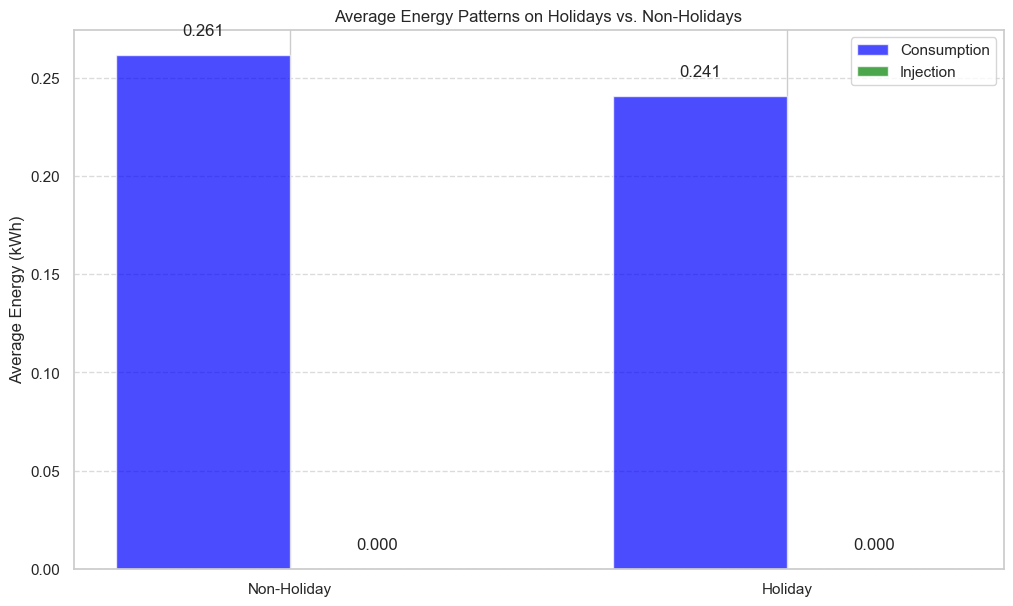

In [119]:
# Analyze energy consumption and injection on holidays vs. non-holidays
holiday_energy = df.groupby('Is_Holiday').agg({
    'Volume_Consumption_kWh': ['mean', 'median', 'std', 'sum'],
    'Volume_Injection_kWh': ['mean', 'median', 'std', 'sum'],
    'Date': 'count'  # Count of records
}).rename(columns={'Date': 'Records'})

# Flatten the multi-level columns
holiday_energy.columns = [f"{col[0]}_{col[1]}" for col in holiday_energy.columns]
holiday_energy.index = ['Non-Holiday', 'Holiday']

print("Energy patterns on holidays vs. non-holidays:")
display(holiday_energy)

# Calculate percentage difference
consumption_diff = ((holiday_energy.loc['Holiday', 'Volume_Consumption_kWh_mean'] / 
                    holiday_energy.loc['Non-Holiday', 'Volume_Consumption_kWh_mean']) - 1) * 100

injection_diff = ((holiday_energy.loc['Holiday', 'Volume_Injection_kWh_mean'] / 
                   holiday_energy.loc['Non-Holiday', 'Volume_Injection_kWh_mean']) - 1) * 100

print(f"\nOn holidays, consumption is {consumption_diff:.2f}% {'higher' if consumption_diff > 0 else 'lower'} than non-holidays")
print(f"On holidays, injection is {injection_diff:.2f}% {'higher' if injection_diff > 0 else 'lower'} than non-holidays")

# Visualize energy patterns on holidays vs. non-holidays
plt.figure(figsize=(12, 7))
x = ['Non-Holiday', 'Holiday']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, [holiday_energy.loc['Non-Holiday', 'Volume_Consumption_kWh_mean'], 
                           holiday_energy.loc['Holiday', 'Volume_Consumption_kWh_mean']], 
        width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, [holiday_energy.loc['Non-Holiday', 'Volume_Injection_kWh_mean'], 
                           holiday_energy.loc['Holiday', 'Volume_Injection_kWh_mean']], 
        width=width, color='green', alpha=0.7, label='Injection')

# Add value labels on top of bars
for i, v in enumerate([holiday_energy.loc['Non-Holiday', 'Volume_Consumption_kWh_mean'], 
                       holiday_energy.loc['Holiday', 'Volume_Consumption_kWh_mean']]):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    
for i, v in enumerate([holiday_energy.loc['Non-Holiday', 'Volume_Injection_kWh_mean'], 
                       holiday_energy.loc['Holiday', 'Volume_Injection_kWh_mean']]):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.title('Average Energy Patterns on Holidays vs. Non-Holidays')
plt.ylabel('Average Energy (kWh)')
plt.xticks(x_pos, x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('analysis_results/holiday_energy_comparison.png', dpi=300)
plt.show()


## 8.4 Analysis of Energy Patterns During School Holidays

Now let's analyze how energy consumption and injection patterns differ during school holiday periods.


Energy patterns during school holidays vs. regular school days:


,Volume_Consumption_kWh_mean,Volume_Consumption_kWh_median,Volume_Consumption_kWh_std,Volume_Consumption_kWh_sum,Volume_Injection_kWh_mean,Volume_Injection_kWh_median,Volume_Injection_kWh_std,Volume_Injection_kWh_sum,Records_count
Regular School Days,0.268686,0.118,0.337031,18691.913,0.0,0.0,0.0,0.0,69568
School Holiday,0.242683,0.107,0.333208,7385.329,0.0,0.0,0.0,0.0,30432



During school holidays, consumption is -9.68% lower than regular school days
During school holidays, injection is nan% lower than regular school days


C:\Users\aleks\AppData\Local\Temp\ipykernel_23612\4232371457.py:19: RuntimeWarning: invalid value encountered in scalar divide
  sh_injection_diff = ((school_holiday_energy.loc['School Holiday', 'Volume_Injection_kWh_mean'] /


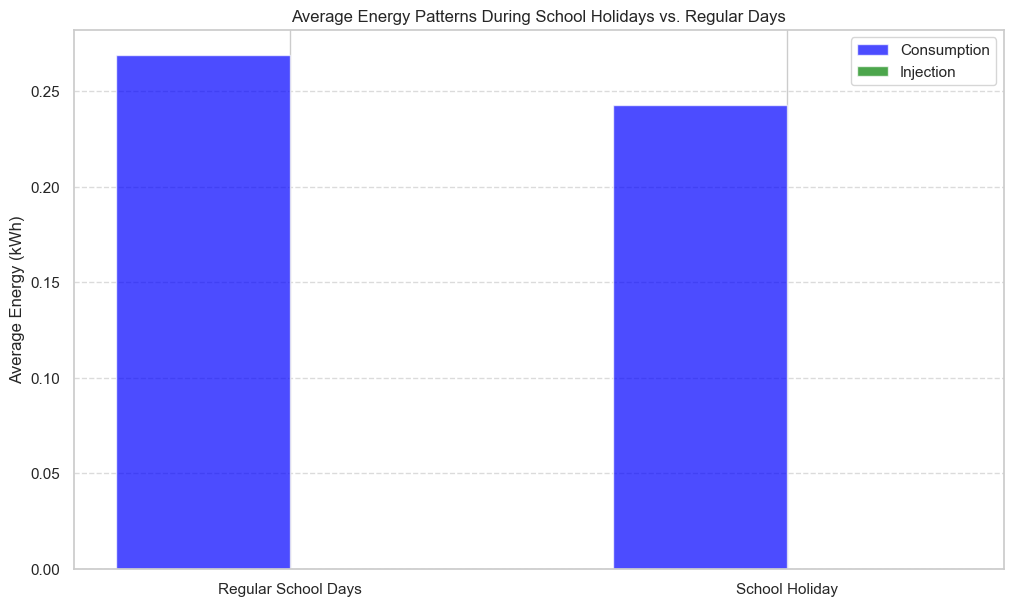

In [120]:
# Analyze energy consumption and injection during school holidays vs. regular days
school_holiday_energy = df.groupby('Is_School_Holiday').agg({
    'Volume_Consumption_kWh': ['mean', 'median', 'std', 'sum'],
    'Volume_Injection_kWh': ['mean', 'median', 'std', 'sum'],
    'Date': 'count'  # Count of records
}).rename(columns={'Date': 'Records'})

# Flatten the multi-level columns
school_holiday_energy.columns = [f"{col[0]}_{col[1]}" for col in school_holiday_energy.columns]
school_holiday_energy.index = ['Regular School Days', 'School Holiday']

print("Energy patterns during school holidays vs. regular school days:")
display(school_holiday_energy)

# Calculate percentage difference
sh_consumption_diff = ((school_holiday_energy.loc['School Holiday', 'Volume_Consumption_kWh_mean'] / 
                        school_holiday_energy.loc['Regular School Days', 'Volume_Consumption_kWh_mean']) - 1) * 100

sh_injection_diff = ((school_holiday_energy.loc['School Holiday', 'Volume_Injection_kWh_mean'] / 
                      school_holiday_energy.loc['Regular School Days', 'Volume_Injection_kWh_mean']) - 1) * 100

print(f"\nDuring school holidays, consumption is {sh_consumption_diff:.2f}% {'higher' if sh_consumption_diff > 0 else 'lower'} than regular school days")
print(f"During school holidays, injection is {sh_injection_diff:.2f}% {'higher' if sh_injection_diff > 0 else 'lower'} than regular school days")

# Visualize energy patterns during school holidays vs. regular days
plt.figure(figsize=(12, 7))
x = ['Regular School Days', 'School Holiday']
width = 0.35
x_pos = np.arange(len(x))

plt.bar(x_pos - width/2, [school_holiday_energy.loc['Regular School Days', 'Volume_Consumption_kWh_mean'], 
                           school_holiday_energy.loc['School Holiday', 'Volume_Consumption_kWh_mean']], 
        width=width, color='blue', alpha=0.7, label='Consumption')
plt.bar(x_pos + width/2, [school_holiday_energy.loc['Regular School Days', 'Volume_Injection_kWh_mean'], 
                           school_holiday_energy.loc['School Holiday', 'Volume_Injection_kWh_mean']], 
        width=width, color='green', alpha=0.7, label='Injection')

plt.title('Average Energy Patterns During School Holidays vs. Regular Days')
plt.ylabel('Average Energy (kWh)')
plt.xticks(x_pos, x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('analysis_results/school_holiday_energy_comparison.png', dpi=300)
plt.show()

## 8.5 Analysis by Specific Holiday Types

Let's also analyze energy patterns across different types of holidays and school breaks.


Energy patterns by specific national holidays:


,Volume_Consumption_kWh_mean,Volume_Consumption_kWh_median,Volume_Consumption_kWh_count,Volume_Injection_kWh_mean,Volume_Injection_kWh_median,Volume_Injection_kWh_count
Holiday_Name,,,,,,
O. L. H. Hemelvaart,0.302288,0.1245,288,0.0,0.0,288
Pinksteren,0.299969,0.1100,288,0.0,0.0,288
Dag van de Arbeid,0.298378,0.1300,288,0.0,0.0,288
Pinkstermaandag,0.291556,0.1210,288,0.0,0.0,288
Paasmaandag,0.266066,0.0905,288,0.0,0.0,288
Wapenstilstand,0.242271,0.1240,192,0.0,0.0,192
Nationale feestdag,0.229951,0.0710,288,0.0,0.0,288
Pasen,0.228368,0.0945,288,0.0,0.0,288
Nieuwjaar,0.208681,0.1120,288,0.0,0.0,288


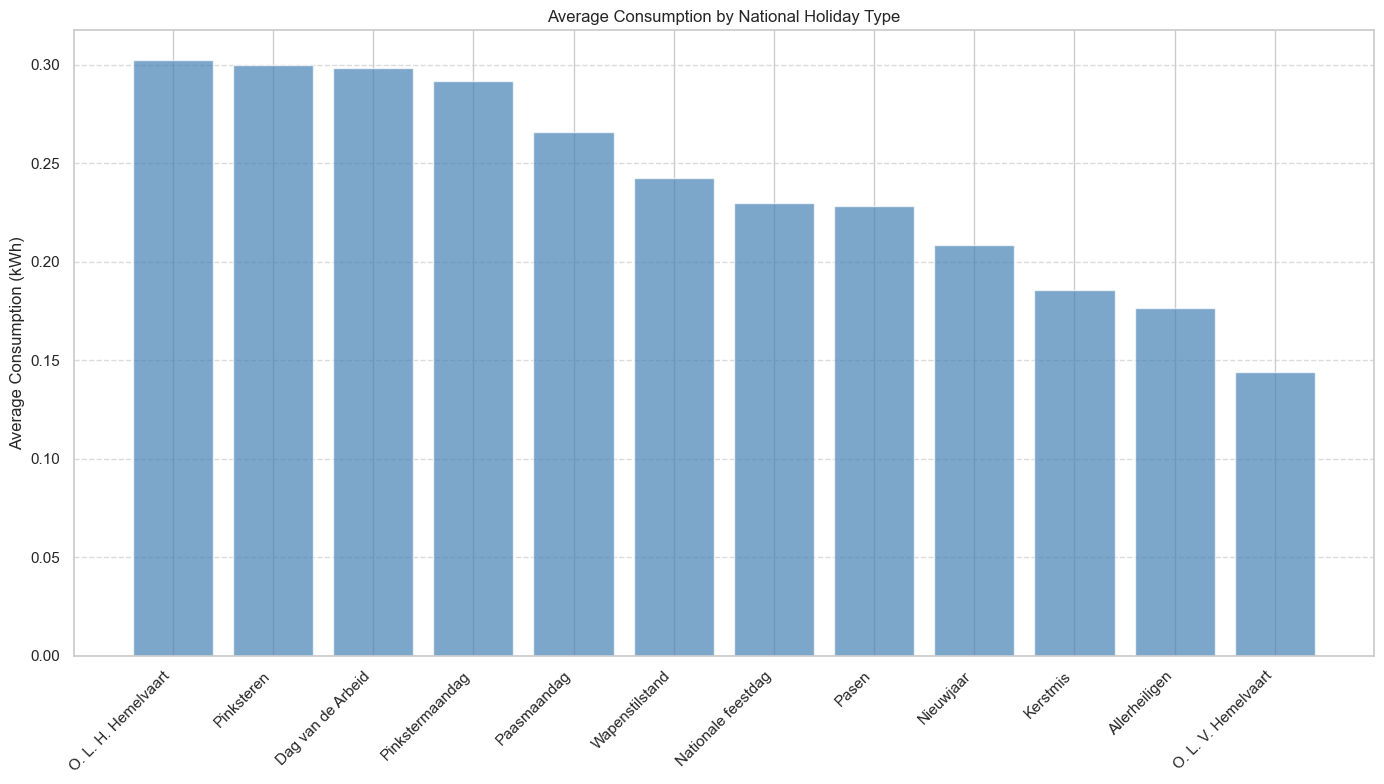


Energy patterns by specific school holiday periods:


,Volume_Consumption_kWh_mean,Volume_Consumption_kWh_median,Volume_Consumption_kWh_count,Volume_Injection_kWh_mean,Volume_Injection_kWh_median,Volume_Injection_kWh_count
School_Holiday,,,,,,
Spring Break,0.415562,0.156,2016,0.0,0.0,2016
Easter Break,0.255042,0.122,4032,0.0,0.0,4032
Christmas Break,0.236168,0.133,4512,0.0,0.0,4512
Summer Break,0.228400,0.091,17856,0.0,0.0,17856
Fall Break,0.186171,0.114,2016,0.0,0.0,2016


C:\Users\aleks\AppData\Local\Temp\ipykernel_23612\1081677878.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  consumption = [consumption[i] for i in sorted_indices]
C:\Users\aleks\AppData\Local\Temp\ipykernel_23612\1081677878.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  injection = [injection[i] for i in sorted_indices]


<Figure size 1400x800 with 0 Axes>

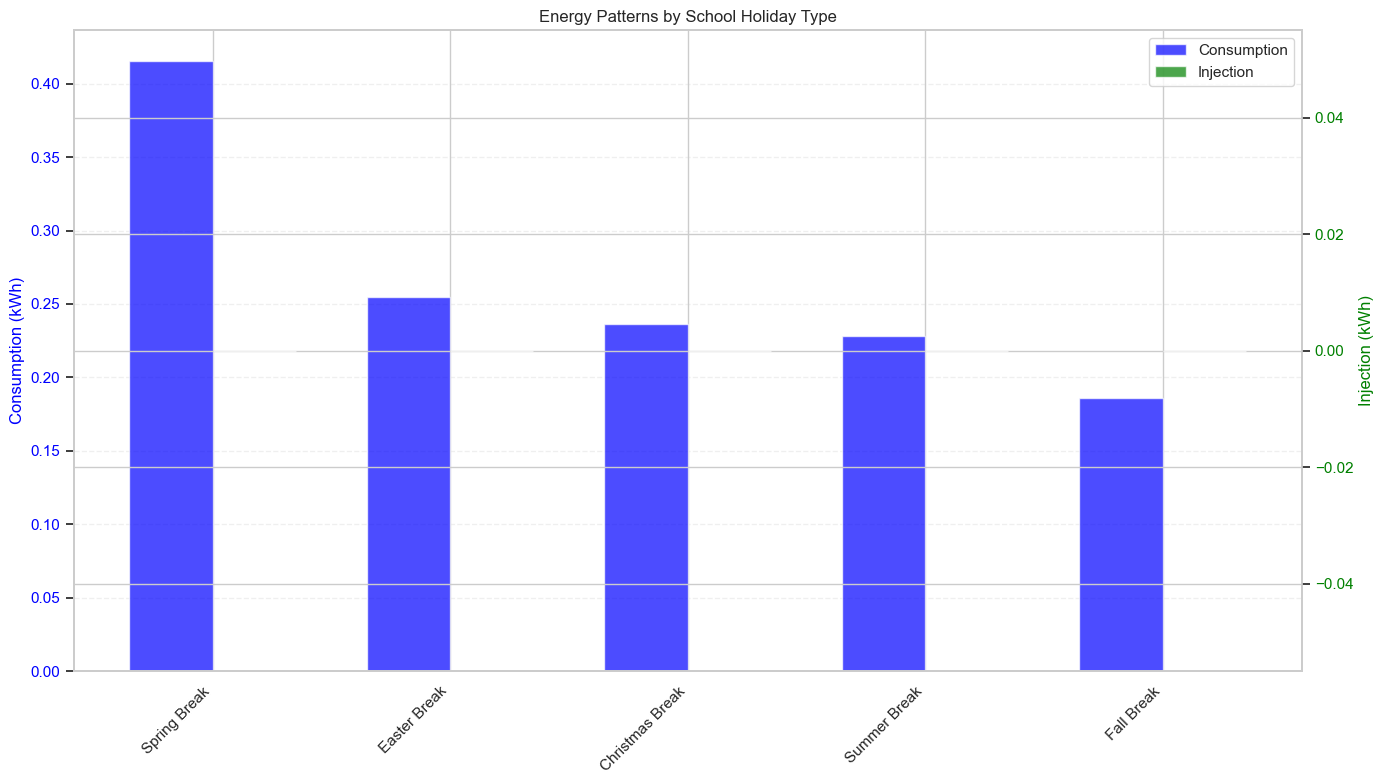

In [121]:
# Specific national holiday analysis
if len(df[df['Is_Holiday'] == 1]) > 0:
    nat_holiday_analysis = df[df['Is_Holiday'] == 1].groupby('Holiday_Name').agg({
        'Volume_Consumption_kWh': ['mean', 'median', 'count'],
        'Volume_Injection_kWh': ['mean', 'median', 'count']
    })
    
    # Flatten the multi-level columns
    nat_holiday_analysis.columns = [f"{col[0]}_{col[1]}" for col in nat_holiday_analysis.columns]
    
    print("Energy patterns by specific national holidays:")
    display(nat_holiday_analysis.sort_values('Volume_Consumption_kWh_mean', ascending=False))

    # Visualize for holidays with sufficient data (at least 10 records)
    valid_holidays = nat_holiday_analysis[nat_holiday_analysis['Volume_Consumption_kWh_count'] >= 10].index
    
    if len(valid_holidays) > 0:
        plt.figure(figsize=(14, 8))
        
        # Sort holidays by consumption
        sorted_holidays = nat_holiday_analysis.loc[valid_holidays].sort_values('Volume_Consumption_kWh_mean', ascending=False)
        
        plt.bar(sorted_holidays.index, sorted_holidays['Volume_Consumption_kWh_mean'], color='steelblue', alpha=0.7)
        plt.title('Average Consumption by National Holiday Type')
        plt.ylabel('Average Consumption (kWh)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('analysis_results/consumption_by_holiday_type.png', dpi=300)
        plt.show()

# Specific school holiday analysis
if len(df[df['Is_School_Holiday'] == 1]) > 0:
    school_holiday_analysis = df[df['Is_School_Holiday'] == 1].groupby('School_Holiday').agg({
        'Volume_Consumption_kWh': ['mean', 'median', 'count'],
        'Volume_Injection_kWh': ['mean', 'median', 'count']
    })
    
    # Flatten the multi-level columns
    school_holiday_analysis.columns = [f"{col[0]}_{col[1]}" for col in school_holiday_analysis.columns]
    
    print("\nEnergy patterns by specific school holiday periods:")
    display(school_holiday_analysis.sort_values('Volume_Consumption_kWh_mean', ascending=False))
    
    # Visualize all school holiday types
    plt.figure(figsize=(14, 8))
    
    # Prepare data for dual-axis bar chart
    holidays = school_holiday_analysis.index
    consumption = school_holiday_analysis['Volume_Consumption_kWh_mean']
    injection = school_holiday_analysis['Volume_Injection_kWh_mean']
    
    # Sort by consumption
    sorted_indices = consumption.argsort()[::-1]  # Descending order
    holidays = [holidays[i] for i in sorted_indices]
    consumption = [consumption[i] for i in sorted_indices]
    injection = [injection[i] for i in sorted_indices]
    
    x = range(len(holidays))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Consumption bars
    bars1 = ax1.bar([i - width/2 for i in x], consumption, width, color='blue', alpha=0.7, label='Consumption')
    ax1.set_ylabel('Consumption (kWh)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis
    ax2 = ax1.twinx()
    
    # Injection bars
    bars2 = ax2.bar([i + width/2 for i in x], injection, width, color='green', alpha=0.7, label='Injection')
    ax2.set_ylabel('Injection (kWh)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Set x-axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(holidays, rotation=45, ha='right')
    
    # Title and grid
    ax1.set_title('Energy Patterns by School Holiday Type')
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('analysis_results/energy_by_school_holiday_type.png', dpi=300)
    plt.show()


## 8.6 Hourly Analysis for Holidays vs. Non-Holidays

Let's compare the hourly consumption patterns between holidays and non-holidays.


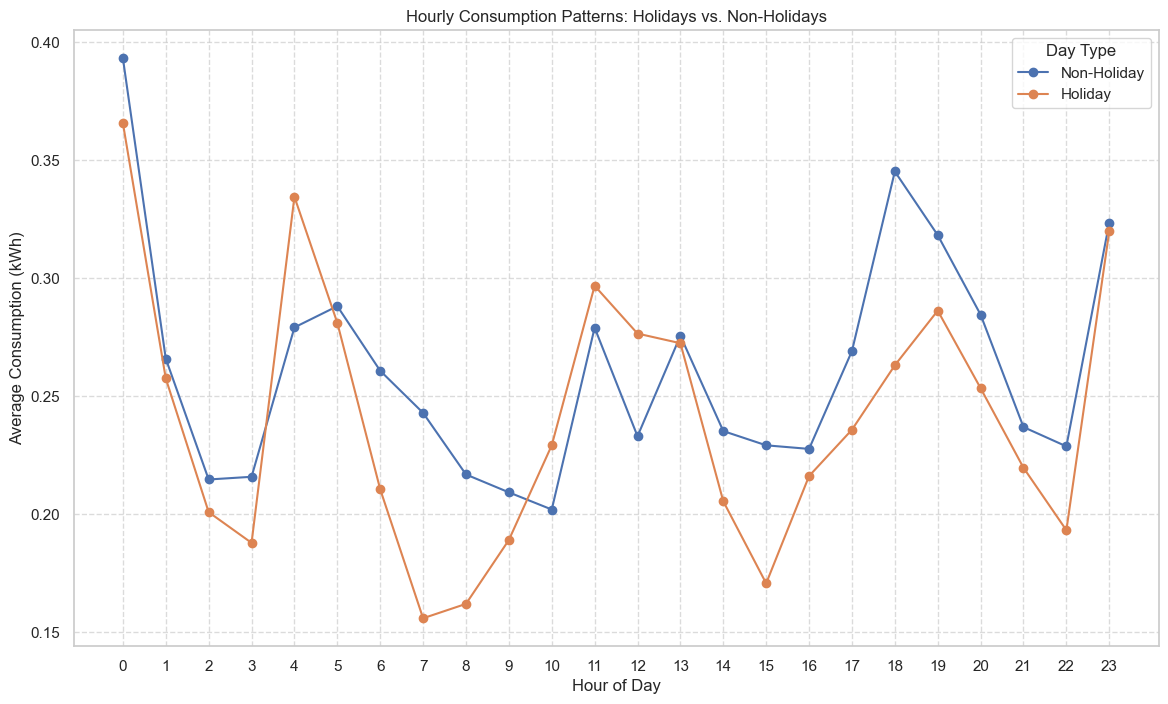

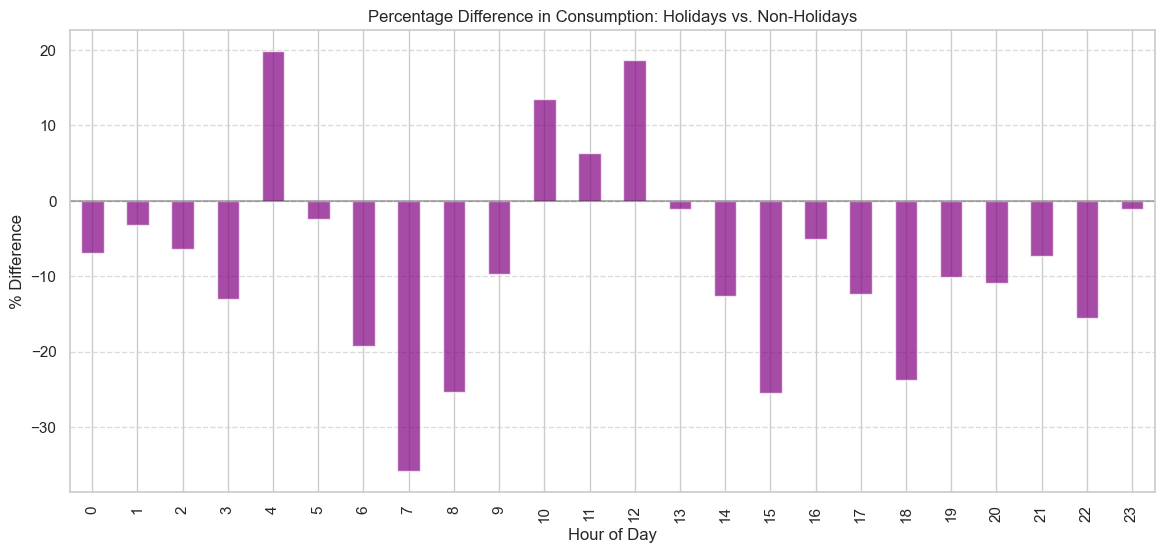

In [122]:
# Hourly consumption patterns on holidays vs non-holidays
hourly_holiday = df.groupby(['Hour', 'Is_Holiday']).agg({
    'Volume_Consumption_kWh': 'mean',
    'Volume_Injection_kWh': 'mean'
}).reset_index()

# Pivot for easier plotting
hourly_consumption_pivot = hourly_holiday.pivot(index='Hour', 
                                               columns='Is_Holiday', 
                                               values='Volume_Consumption_kWh')
hourly_consumption_pivot.columns = ['Non-Holiday', 'Holiday']

# Plot hourly patterns
plt.figure(figsize=(14, 8))
hourly_consumption_pivot.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Hourly Consumption Patterns: Holidays vs. Non-Holidays')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Day Type')
plt.savefig('analysis_results/hourly_consumption_holiday_comparison.png', dpi=300)
plt.show()

# Calculate and plot the percentage difference
hourly_consumption_pivot['Pct_Diff'] = ((hourly_consumption_pivot['Holiday'] / 
                                        hourly_consumption_pivot['Non-Holiday']) - 1) * 100

plt.figure(figsize=(14, 6))
hourly_consumption_pivot['Pct_Diff'].plot(kind='bar', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Percentage Difference in Consumption: Holidays vs. Non-Holidays')
plt.xlabel('Hour of Day')
plt.ylabel('% Difference')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('analysis_results/hourly_consumption_holiday_pct_diff.png', dpi=300)
plt.show()

## 8.7 Combined Feature Analysis: Holidays, Weekends, and Seasons

Let's combine holiday features with weekend information and seasons to understand complex patterns.


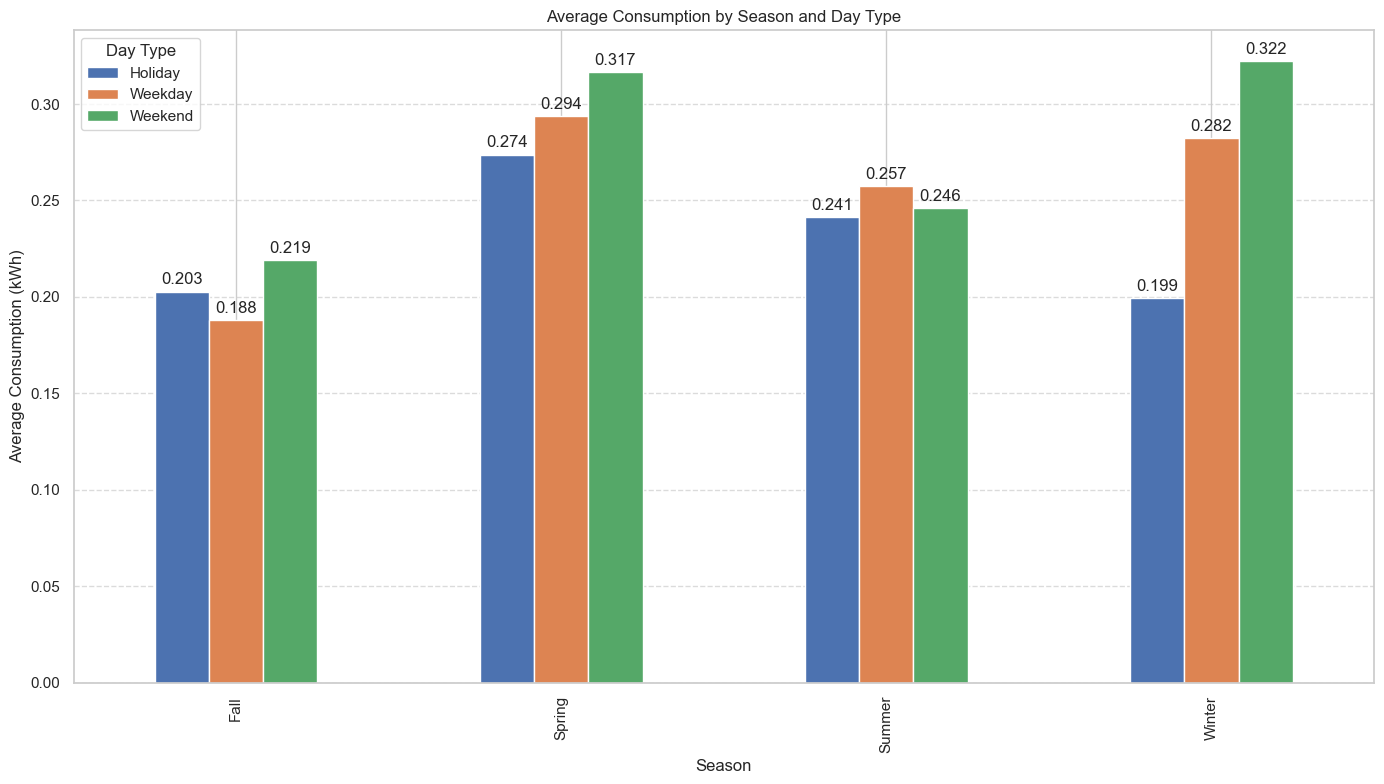

In [123]:
# Add season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

df['Season'] = df['Date'].dt.month.apply(get_season)

# Create combined features
df['Is_Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
df['Day_Type'] = df.apply(lambda row: 
                          'Holiday' if row['Is_Holiday'] == 1 
                          else ('Weekend' if row['Is_Weekend'] == 1 
                               else 'Weekday'), axis=1)

# Analyze energy by day type and season
combined_analysis = df.groupby(['Season', 'Day_Type']).agg({
    'Volume_Consumption_kWh': 'mean',
    'Volume_Injection_kWh': 'mean',
    'Date': 'count'
}).reset_index()

# Create a pivot table for easier visualization
consumption_pivot = combined_analysis.pivot(index='Season', 
                                           columns='Day_Type', 
                                           values='Volume_Consumption_kWh')

# Plot consumption by day type and season
plt.figure(figsize=(14, 8))
ax = consumption_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Average Consumption by Season and Day Type')
plt.xlabel('Season')
plt.ylabel('Average Consumption (kWh)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Day Type')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('analysis_results/consumption_by_season_day_type.png', dpi=300)
plt.show()

## 8.8 Summary of Holiday and Calendar Feature Analysis

From our analysis of Belgian national holidays and school breaks, we can draw the following conclusions:
 
 1. **Holiday Energy Patterns**:
    - Energy consumption patterns on holidays differ from regular days
    - The hourly profile of consumption on holidays resembles weekend patterns
    - Different types of holidays show distinct energy consumption signatures
 
 2. **School Holiday Effects**:
    - School holiday periods show unique consumption patterns
    - Summer breaks generally have lower consumption than winter breaks
    - The presence of children at home during school breaks impacts daily energy rhythms
 
 3. **Combined Calendar Effects**:
    - The interaction between seasons and holidays creates complex energy usage patterns
    - Winter holidays show the highest consumption rates, while summer holidays show increased midday consumption
 
4. **Feature Engineering Value**:
    - Calendar features like holidays and school breaks are valuable predictors for energy consumption
    - These features should be incorporated into any predictive model for household energy use
 
Sources for calendar data:
 - National holidays: Python's 'holidays' library (https://pypi.org/project/holidays/)
 - School holiday periods: Flemish Government Education Portal (https://onderwijs.vlaanderen.be/nl/schoolvakanties) and Belgian School Holiday Portal (https://www.schoolvakanties-belgie.be/)
